# Testing multiclass_MLP_v2 model with real world images

In [2]:
import cv2
import os
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from tensorflow import keras
import sys
sys.path.append("/multiclass_MLP_v2")

def load_add_operator_dataset():
  images_names = os.listdir("../datasets/full_+_preprocessed/")
  add_images = []
  for img_name in images_names:
    image = cv2.imread('../datasets/full_+_preprocessed/'+ img_name, 0)

    add_images.append(image)

  # Convert image to numpy array to match MNIST datatype
  images = np.asarray(add_images)

  # Load labels
  image_labels = create_add_operator_labels()

  # Convert labels to numpy array to match MNIST datatype
  image_labels = np.asanyarray(image_labels)

  # Remove 14% for test
  # X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
  labels_frac = math.ceil(len(image_labels) * (1/7)) # >>> 604
  images_test, images_train = images[:labels_frac] / 255., images[labels_frac:] / 255. 
  labels_test, labels_train = image_labels[:labels_frac], image_labels[labels_frac:]

  # Take another 8% for validation set, remainder stays in train
  labels_frac = math.ceil(len(image_labels) * (.5/6)) # >>> 353
  images_valid, images_train = images[:labels_frac] / 255., images[labels_frac:] / 255. 
  labels_valid, labels_train = image_labels[:labels_frac], image_labels[labels_frac:] 

  return images_train, images_valid, images_test, labels_train, labels_valid, labels_test


# Create float labels for every item in directory
def create_add_operator_labels():
  preprocessed_image_names = os.listdir("../datasets/full_+_preprocessed/")
  add_labels = 10
  y_add_labels = [add_labels for img in range(len(preprocessed_image_names))]

  return np.asarray(y_add_labels)

# @brief Generate data subsets for neural net model.
def create_mnist_train_test():
  # number of images, 28x28 pixels
  # Shape: X:(60000, 28, 28), Y:(10000, 28, 28)
  (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

  # Create validation set and convert to float in 0-1 range
  X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
  y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
  X_test = X_test / 255.

  # Get add operator dataset with labels
  add_train, add_valid, add_test, y_add_train, y_add_valid, y_add_test = load_add_operator_dataset()

  # Add add images to MNIST 
  X_train_new = np.concatenate((X_train, add_train))
  X_test_new = np.concatenate((X_test, add_test))
  X_valid_new = np.concatenate((X_valid, add_valid))
  del add_train, add_valid, add_test

  y_train_new = np.concatenate((y_train, y_add_train))
  y_valid_new = np.concatenate((y_valid, y_add_valid))
  y_test_new = np.concatenate((y_test, y_add_test))
  del y_add_train, y_add_valid, y_add_test

  # Shuffle images and labels
  idx = np.random.permutation(len(y_train_new))
  X_train_new_sh, y_train_new_sh = X_train_new[idx], y_train_new[idx]

  idx = np.random.permutation(len(y_valid_new))
  X_valid_new_sh, y_valid_new_sh = X_valid_new[idx], y_valid_new[idx]

  idx = np.random.permutation(len(y_test_new))
  X_test_new_sh, y_test_new_sh = X_test_new[idx], y_test_new[idx]

  return  X_train_new_sh, X_valid_new_sh, X_test_new_sh, y_train_new_sh, y_valid_new_sh, y_test_new_sh


2022-12-30 16:30:06.085679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# LOAD THE MOST RECENT MODEL
X_train,  X_valid, X_test, y_train, y_valid, y_test = create_mnist_train_test()
model = keras.models.load_model("../multiclass_MLP_v2")
print(model.evaluate(X_test, y_test))

2022-12-30 16:30:25.173043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


332/332 [==============================] - 3s 5ms/step - loss: 0.0942 - accuracy: 0.9844
[0.09420761466026306, 0.9844398498535156]



----------------Contoured Image--------------------
INFO: 0 contour(s) removed containing a pixel area less than 25
INFO: num of contours found:  3


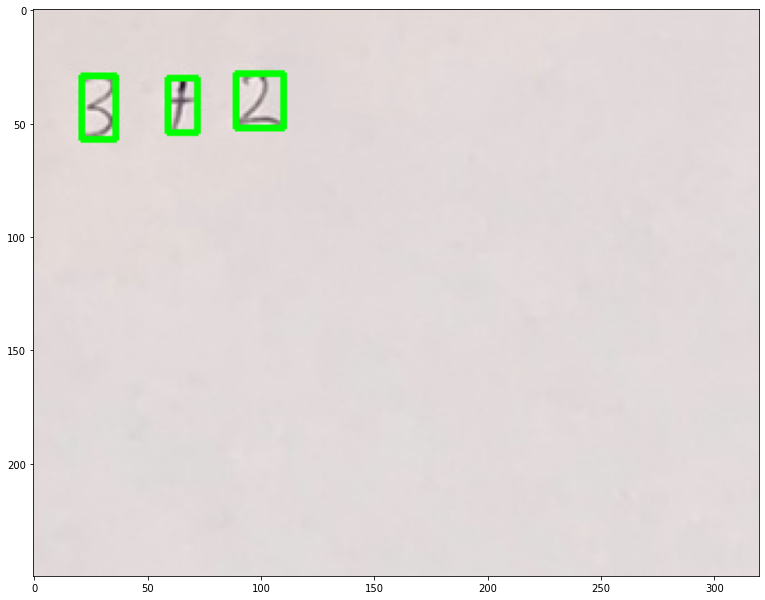

1/1 [==============================] - 0s 27ms/step


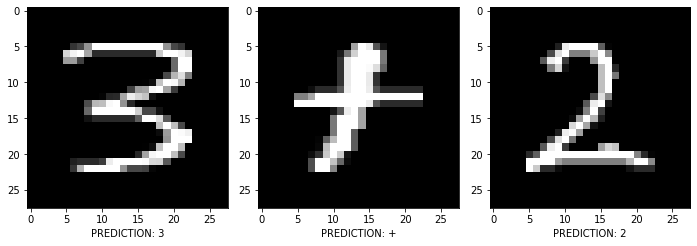

>>> Equation Output >>>
3 + 2 = 5


In [4]:
# @brief Perform preprocessing to convert a single image into multiple MNIST like images.
#     This function assumes that the image will sctrictly contain only numbers and arithmetic operators
# 
# @note The contouring algorithm used doesn't generate the contours left to right, hence
#     the need for sorting the the digts based on their x-axis position before returning
#
# @return Number of contours with pixel area less than 25
# @return List of 28 x 28 pixel grayscale images
# @ TODO Order the images in order from left to right
def multi_preprocess_pipeline(image):
    # Greyscale and contour the input image
    grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(grey.copy(), 75, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Perform preprocessing on contours found within image
    preprocessed_digits = []
    x_center_positions = []
    pxl_area_lt_25 = 0
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)

        # Remove contours that have a pixel area less than 25 (EX: (x=5) * (y=5) = 25)
        img_pixel_area = w * h
        if (img_pixel_area < 25):
            pxl_area_lt_25 += 1
            continue

        # Get the X-axis center of an image. This will later be used
        # to resort the contours from left to right to be able to 
        # solve a handwritten equation
        xCenter = int((x + (x+w)) / 2)
        x_center_positions.append(xCenter)

        # Creating a rectangle around the digit in the original image (for displaying the digits fetched via contours)
        cv2.rectangle(image, (x,y), (x+w, y+h), color=(0, 255, 0), thickness=2)
        
        # Cropping out the digit from the image corresponding to the current contours in the for loop
        digit = thresh[y:y+h, x:x+w]
        
        # Get the x and y pixel length of the contour found in the image
        x, y = digit.shape
        padded_digit = digit.copy()

        if (y < 10):
            # Padd x-axis; Prevents narrow images from getting rezied 
            # into square like shapes
            difference = round((28 - y)/2)
            padded_digit = np.pad(padded_digit, ((0,0),(difference,difference)),"constant", constant_values=0)

        # Resize digit
        resized_digit = cv2.resize(padded_digit, (18,18))
        
        # Padding the digit with 5 pixels of black color (zeros) in each side to finally produce the image of (28, 28)
        padded_digit = np.pad(resized_digit, ((5,5),(5,5)), "constant", constant_values=0)
        
        # Adding the preprocessed digit to the list of preprocessed digits
        preprocessed_digits.append(padded_digit)
        
    # Sort the x positions of contours in ascending order 
    # This means smallest contour xCenter would be the first index
    sorted_indexes = np.argsort(x_center_positions)

    # Sort the "preprocessed_digits" using new sorted indicies
    sorted_digits = []
    for i in sorted_indexes:
        sorted_digits.append(preprocessed_digits[i])

    return pxl_area_lt_25, sorted_digits


# @brief Preprocess list of images into 4 column grid
#
# @return list of labels for every image in the "images_list"
def display_images_with_predictions(images_list):
  num_columns = 4

  rows = math.ceil( len(images_list) / num_columns)

  fig = plt.figure(figsize=(13,13), tight_layout = True)

  predictions = []
  for i in range(0, len(images_list)):
    prediction = model.predict(images_list[i].reshape(1, 28, 28, 1))

    # Labels for add operator are 10 while the other digits hold
    # values 0-9
    pred_label = np.argmax(prediction)
    if (pred_label == 10):
        pred_label = "+"

    predictions.append(pred_label)

    fig.add_subplot(rows, num_columns, i + 1)
    plt.xlabel('PREDICTION: {0}'.format(pred_label), fontsize=10)    
    plt.imshow(images_list[i], cmap='gray')

    plt.imshow(images_list[i], cmap='gray')

  plt.show()

  return predictions


# Convert model predictions into a string equation for later evaluation
def create_equation_str(prediction_labels):
    equation = ""
    for item in prediction_labels:

        if (item == "+"):
            equation += item + " "
            continue
        
        equation += str(item) + " "

    return equation


# ---------------- MAIN ----------------
image = cv2.imread("./IMG_8965.jpg")

invalid_imgs, processed_images = multi_preprocess_pipeline(image)

print("\n----------------Contoured Image--------------------")
print(f"INFO: {invalid_imgs} contour(s) removed containing a pixel area less than 25")

print("INFO: num of contours found: ", len(processed_images))
fig = plt.figure(figsize=(13,13))
plt.imshow(image, cmap="gray")
plt.show()
    

# Display images with printed values
predictions = display_images_with_predictions(processed_images)

eq = create_equation_str(predictions)
print(">>> Equation Output >>>")
print(eq + "= " + str(eval(eq)))


Testing with another image


----------------Contoured Image--------------------
INFO: 1 contour(s) removed containing a pixel area less than 25
INFO: num of contours found:  3


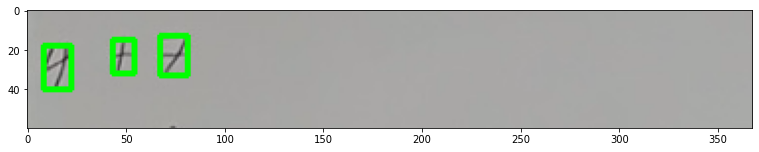

1/1 [==============================] - 0s 25ms/step


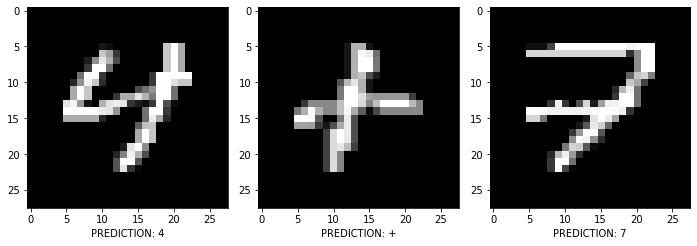

>>> Equation Output >>>
4 + 7 = 11


In [5]:
# ---------------- MAIN ----------------
image = cv2.imread("./IMG_8942_2.jpg")

invalid_imgs, processed_images = multi_preprocess_pipeline(image)

print("\n----------------Contoured Image--------------------")
print(f"INFO: {invalid_imgs} contour(s) removed containing a pixel area less than 25")

print("INFO: num of contours found: ", len(processed_images))
fig = plt.figure(figsize=(13,13))
plt.imshow(image, cmap="gray")
plt.show()
    

# Display images with printed values
predictions = display_images_with_predictions(processed_images)

eq = create_equation_str(predictions)
print(">>> Equation Output >>>")
print(eq + "= " + str(eval(eq)))